# Understanding cross-correlation

In [1]:
from scipy import signal
import numpy as np
from numpy.fft import fft, ifft, fft2, ifft2, fftshift
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.animation as animation
from wand.image import Image
from wand.display import display
from celluloid import Camera

In [2]:
sns.set(context='talk', style='ticks', palette='muted')

## simulate eye hand signals

In [3]:
def createSignal(
    amplitude,
    freqList, 
    lenSignal, 
    timePeriod, 
    burstFreq, 
    burstTime, 
    dc_offset,
    noise_level
):
    np.random.seed(seed=42)
    
    t = np.linspace(timePeriod[0], timePeriod[1], lenSignal)
    
    signal =  amplitude * np.sin(np.pi * 2. * burstFreq * t)
    
    signal[np.logical_or(t < burstTime[0], t > burstTime[1])] = 0
    
    on_time = np.logical_and(t >= burstTime[0], t <= burstTime[1])
    
    signal = signal + dc_offset + np.random.normal(noise_level, 1, size=lenSignal) 
    
#     signal[on_time] *= np.hanning(on_time.sum()) 
    
#     for f in freqList:
#         signal = signal + np.sin(2*np.pi*f*t)
        
    return signal

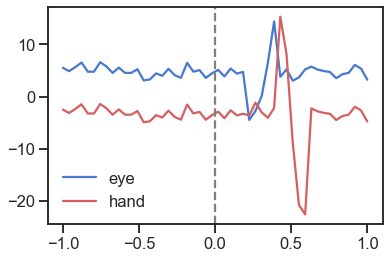

In [31]:
freqList = [1]
N = 50
noise_level = 2
timePeriod = [-1, 1]
t = np.linspace(*timePeriod, N)
burstFreq = 3
burstTime = [0.2, 0.4]
dc_offset = 3
amplitude = 10
x = createSignal(amplitude, freqList, N, timePeriod, burstFreq, burstTime, dc_offset, noise_level)
plt.plot(t, x, color='b', label='eye')
burstFreq = 3
burstTime = [0.4, 0.6]
dc_offset = -5
amplitude = 20

y = createSignal(amplitude, freqList, N, timePeriod, burstFreq, burstTime, dc_offset, noise_level)
plt.plot(t, y, color='r', label='hand')
plt.legend(frameon=False)

plt.axvline(0, color='grey', ls='--');

## XCORR using scipy.signal.correlate

Delay between signals is: -5


[(-1.0, 1.0)]

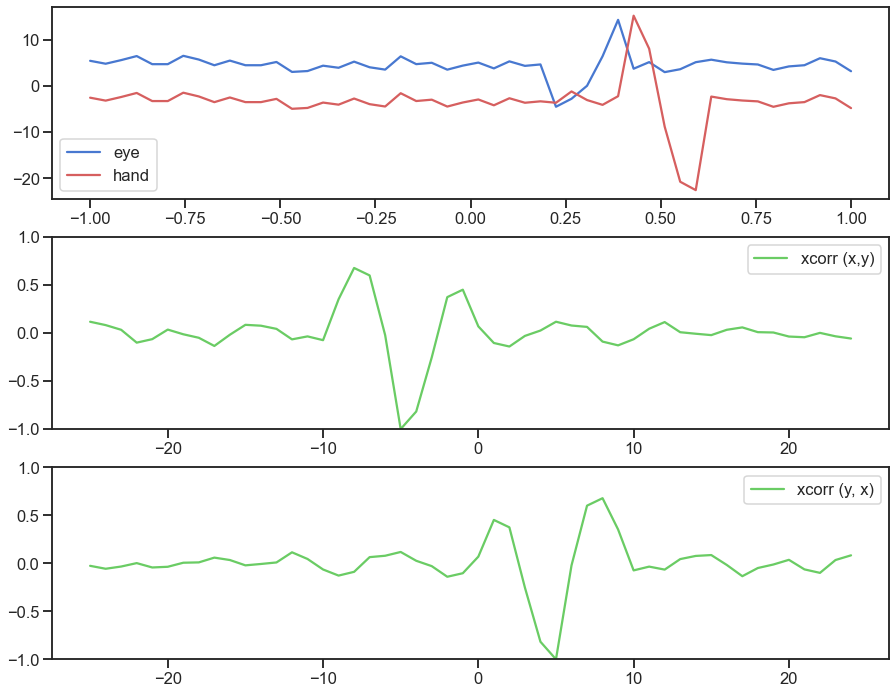

In [32]:
_, ax = plt.subplots(3, 1, figsize=(15,12))
ax = ax.ravel()

ax[0].plot(t, x, color='b', label='eye')
ax[0].plot(t, y, color='r', label='hand')

x = (x-x.mean())
y = (y-y.mean())

corr = signal.correlate(x, y, 'same', 'fft')/len(x)
lags = signal.correlation_lags(len(x), len(y), mode='same')
corr /= np.max(abs(corr))

print(f'Delay between signals is: {lags[np.argmax(abs(corr))]}')
# ax[0].axvline(0, color='grey', ls='--')
ax[1].plot(lags, corr, color='g', label='xcorr (x,y)')
ax[0].legend()
ax[1].legend()

corr = signal.correlate(y, x, 'same','fft')/len(x)
corr /= np.max(abs(corr))
lags = signal.correlation_lags(len(x), len(y), mode='same')
ax[2].plot(lags, corr, color='g', label='xcorr (y, x)')
ax[2].legend()

ax[1].set(ylim=(-1, 1))
ax[2].set(ylim=(-1, 1))

# print(x.shape, corr.shape)

## Compute XCORR using fft

In [33]:
def compute_xcorr_fft(x, y, remove_dc=True):
    if remove_dc:
        x = x - x.mean()
        y = y - y.mean()
    x1 = fft(x)/len(x)
    y1 = fft(np.flipud(y))/len(y)
    xcorr = np.real(ifft(x1 * y1))/len(x)
    xcorr = fftshift(xcorr)
    xcorr /= xcorr.max()
    
    return xcorr

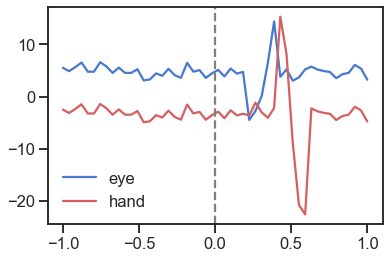

In [34]:
freqList = [1]
N = 50
noise_level = 2
timePeriod = [-1, 1]
t = np.linspace(*timePeriod, N)
burstFreq = 3
burstTime = [0.2, 0.4]
dc_offset = 3
amplitude = 10
x = createSignal(amplitude, freqList, N, timePeriod, burstFreq, burstTime, dc_offset, noise_level)
plt.plot(t, x, color='b', label='eye')
burstFreq = 3
burstTime = [0.4, 0.6]
dc_offset = -5
amplitude = 20

y = createSignal(amplitude, freqList, N, timePeriod, burstFreq, burstTime, dc_offset, noise_level)
plt.plot(t, y, color='r', label='hand')
plt.legend(frameon=False)

plt.axvline(0, color='grey', ls='--');


Delay between signals is: 19


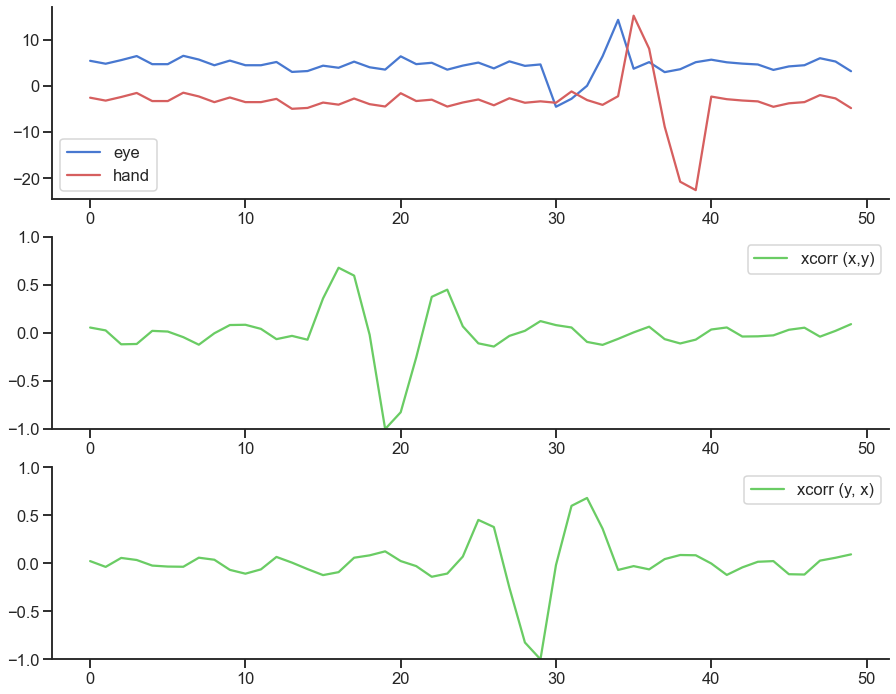

In [35]:
_, ax = plt.subplots(3, 1, figsize=(15,12), sharey=False)
ax = ax.ravel()

corr = compute_xcorr_fft(x, y, True)
corr /= max(abs(corr))
print(f'Delay between signals is: {np.argmax(abs(corr))}')
ax[0].plot(x, color='b', label='eye')
ax[0].plot(y, color='r', label='hand')
ax[1].plot(corr, color='g', label='xcorr (x,y)')
ax[0].legend()
ax[1].legend()

corr = compute_xcorr_fft(y, x, True)
corr /= max(abs(corr))
ax[2].plot(corr, color='g', label='xcorr (y, x)')
ax[2].legend()
ax[1].set(ylim=(-1, 1))
ax[2].set(ylim=(-1, 1))
sns.despine()

Switching signals gives mirrored cross-corr

## Animated XCorr

In [15]:
def get_signal(N):
    N = 50
    noise_level = 2
    timePeriod = [-1, 1]
    t = np.linspace(*timePeriod, N)
    burstFreq = 3
    burstTime = [0.2, 0.4]
    dc_offset = 1
    amplitude = 10
    # signal 1
    x = createSignal(amplitude, freqList, N, timePeriod, burstFreq, burstTime, dc_offset, noise_level)

    burstFreq = 3
    burstTime = [0.4, 0.6]
    dc_offset = -1
    amplitude = 20
    # signal 2
    y = createSignal(amplitude, freqList, N, timePeriod, burstFreq, burstTime, dc_offset, noise_level)
    
    return x, y, t

def get_Rxy(x, y, mu_x, sigma_x, mu_y, sigma_y, N):  
    
    Rxy_tau = sum((x - mu_x)*(y - mu_y))/(sigma_x * sigma_y * N) 
        
    return Rxy_tau

def calculate_xcorr():
    # create signals     
    x, y, t = get_signal(60)
    
    # get signal statistics
    mu_x, sigma_x = x.mean(), x.std()
    mu_y, sigma_y = y.mean(), y.std()
    
    assert len(x) == len(y)
    N = len(x)
    
    # pad the main signal    
    padded_x = np.pad(x, (N, 2*N), 'constant')
    
    Rxy = np.array([])
    for idx, tau in enumerate(range(N, 3*N, 1)):      
        padded_y = np.pad(y, (idx, 3*N - idx), 'constant')
        Rxy = np.append(
            Rxy, 
            get_Rxy(
                padded_x[:tau], padded_y[:tau],
                mu_x, sigma_x, mu_y, sigma_y, N
            )
        )
    
    return padded_x, y, Rxy, t, N
    

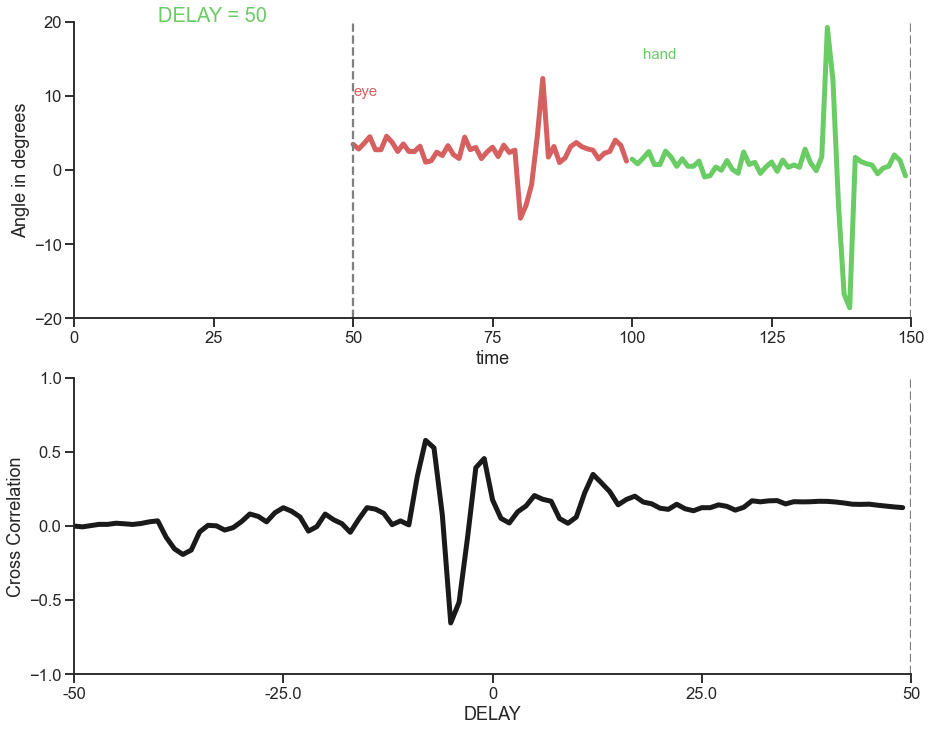

In [36]:
fig, axes = plt.subplots(2, 1, figsize=(15,12), sharex=False)
# fig.subplots_adjust(hspace=2)
camera = Camera(fig)

x, y , xcorr, t, N = calculate_xcorr()


for ind, ax in enumerate(axes):
        ax.spines['right'].set_visible(False)
        ax.spines['top'].set_visible(False)
#         ax.legend()
        if ind != 1:
            ax.set(ylim=(-20,20), xlim=(0,3*N), 
                   yticks=np.arange(-20,21,10), 
                   xticks=np.arange(0,3*N + 1, N/2.),
                   xlabel='time',
                   ylabel='Angle in degrees'
                  )
        else:
            ax.set(ylim=(-1,1), xlim=(0,2*N), 
                   yticks=np.arange(-1,1.1,0.5), 
                   xticks=np.arange(0, 2*N+1, N/2.),
                   xticklabels=[-N, -N/2., 0, N/2., N],
                   xlabel='DELAY',
                   ylabel='Cross Correlation'
                  )



for frame in range(2*N + 1):   
    
    x[x==0] = np.nan
    axes[0].plot(x, color='r', lw=5 )
    axes[0].axvline(frame + N, color='grey', ls='--')
    axes[0].axvline(N, color='grey', ls='--')
    
    padded_y = np.pad(y, (frame, 3*N - frame), 'constant', constant_values=np.nan)
    axes[0].plot(padded_y, color='g', lw=5, )
    
    axes[0].text(    
        15, 20, f'DELAY = {frame - N}', {'color': 'g', 'fontsize': 20},
    )
    axes[0].text(    
        50, 10, 'eye', {'color': 'r', 'fontsize': 15},
    )
    axes[0].text(    
        frame + 2, 15, 'hand', {'color': 'g', 'fontsize': 15},
    )

    axes[1].plot(xcorr[:frame], color='k', lw=5,)
    axes[1].axvline(frame, color='grey', ls='--')    
    
    camera.snap()

animation = camera.animate(interval = 1000,)
animation.save('xcorr.gif')
